<a href="https://github.com/amjadraza/ai-agents-collection/blob/main/Langgraph/langgraph_weather_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%pip install -qU langchain langchain-community langchain_tools tavily-python langgraph langchain_groq

In [4]:
import os
from google.colab import userdata
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

In [5]:
# Importing ChatGroq for using a specific language model
from langchain_groq import ChatGroq
llm=ChatGroq(model="llama-3.3-70b-versatile")

In [7]:
from langchain_community.tools.tavily_search.tool import TavilySearchResults
tavily_search_tool = TavilySearchResults(
    max_results=5,
    include_answer=True,
    include_raw_content=True,
    include_images=True,
    # search_depth="advanced",
    # include_domains = []
    # exclude_domains = []
)


tools = [tavily_search_tool]

In [8]:
tavily_search_tool.invoke({"query": "Any latest news in USA?"})

[{'url': 'https://apnews.com/',
  'content': '[![Image 3: Image](https://dims.apnews.com/dims4/default/dbbfca1/2147483647/strip/true/crop/2949x1964+0+368/resize/599x399!/quality/90/?url=https%3A%2F%2Fassets.apnews.com%2Fe8%2F0a%2Fc377af5f961e0128e91ba2d36dc4%2F4f91966abf024d799157d474fdbd0aea)](https://apnews.com/article/trump-trolling-canada-jill-biden-trudeau-39ecae6554c7b4350e6a106354672eb4) [![Image 4: Image](https://dims.apnews.com/dims4/default/78686e1/2147483647/strip/true/crop/6000x3997+0+2/resize/599x399!/quality/90/?url=https%3A%2F%2Fassets.apnews.com%2F55%2F26%2F09fa12ce1edbded24a1bdefc4a51%2Fa2601074f03248cdab2d041f3a626cbc)](https://apnews.com/article/syria-israel-airstrike-assad-war-b90edb8dbe8268dacf90e59ca601e2e3) [![Image 5: Image](https://dims.apnews.com/dims4/default/e588d90/2147483647/strip/true/crop/4032x2686+0+169/resize/599x399!/quality/90/?url=https%3A%2F%2Fassets.apnews.com%2Ff9%2F96%2F15aa6e41881b7ae9693c3f7edb87%2Fa95369e50d864a3dbca1a33f28f6dbe1)](https://ap

## Chain

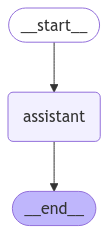

In [9]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(MessagesState)

llm_with_tools = llm.bind_tools(tools)

def assistant(state: MessagesState):
  return {'messages': llm_with_tools.invoke(state['messages'])}


builder.add_node('assistant', assistant)

builder.add_edge(START, 'assistant')
builder.add_edge('assistant', END)

graph = builder.compile()



from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
from pprint import pprint

result = graph.invoke({'messages': ['hello']})

for m in result['messages']:
  m.pretty_print()

================================ Human Message =================================

hello
================================== Ai Message ==================================

I'm happy to chat with you, but I don't see a specific question or topic you'd like to discuss. If you have something on your mind, feel free to ask, and I'll do my best to help.


In [12]:
result = graph.invoke({'messages': ['Is it raining in Karachi, Pakistan?']})

for m in result['messages']:
  m.pretty_print()

================================ Human Message =================================

Is it raining in Karachi, Pakistan?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_pj49)
 Call ID: call_pj49
  Args:
    query: Karachi Pakistan weather


## Router

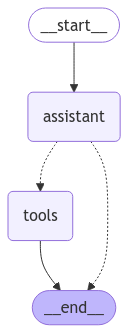

In [13]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(MessagesState)

def assistant(state: MessagesState):
  return {'messages': llm_with_tools.invoke(state['messages'])}


builder.add_node('assistant', assistant)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, 'assistant')
builder.add_conditional_edges('assistant',
                              # if latest message from assistant is a tool call -> tools condition routes to tools node
                              # if latest message from assistant is not a tool call -> routes to END
                              tools_condition)

builder.add_edge('tools', END)

graph = builder.compile()



from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [14]:
result = graph.invoke({'messages': ['Search how is the weather today in Karachi, Pakistan?']})

for m in result['messages']:
  m.pretty_print()

================================ Human Message =================================

Search how is the weather today in Karachi, Pakistan?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_9p99)
 Call ID: call_9p99
  Args:
    query: Karachi Pakistan weather today
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Karachi', 'region': 'Sindh', 'country': 'Pakistan', 'lat': 24.8667, 'lon': 67.05, 'tz_id': 'Asia/Karachi', 'localtime_epoch': 1737402830, 'localtime': '2025-01-21 00:53'}, 'current': {'last_updated_epoch': 1737402300, 'last_updated': '2025-01-21 00:45', 'temp_c': 16.1, 'temp_f': 61.0, 'is_day': 0, 'condition': {'text': 'Mist', 'icon': '//cdn.weatherapi.com/weather/64x64/night/143.png', 'code': 1030}, 'wind_mph': 6.9, 'wind_kph': 11.2, 'wind_degree': 326, 'wind_dir':

In [15]:
import json

tool_output = json.loads(result['messages'][-1].content)

for m in tool_output:
  print(m['url'])
  print(m['content'])
  print()

https://www.weatherapi.com/
{'location': {'name': 'Karachi', 'region': 'Sindh', 'country': 'Pakistan', 'lat': 24.8667, 'lon': 67.05, 'tz_id': 'Asia/Karachi', 'localtime_epoch': 1737402830, 'localtime': '2025-01-21 00:53'}, 'current': {'last_updated_epoch': 1737402300, 'last_updated': '2025-01-21 00:45', 'temp_c': 16.1, 'temp_f': 61.0, 'is_day': 0, 'condition': {'text': 'Mist', 'icon': '//cdn.weatherapi.com/weather/64x64/night/143.png', 'code': 1030}, 'wind_mph': 6.9, 'wind_kph': 11.2, 'wind_degree': 326, 'wind_dir': 'NNW', 'pressure_mb': 1016.0, 'pressure_in': 30.0, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 39, 'cloud': 0, 'feelslike_c': 16.1, 'feelslike_f': 61.0, 'windchill_c': 19.3, 'windchill_f': 66.8, 'heatindex_c': 19.3, 'heatindex_f': 66.8, 'dewpoint_c': 8.5, 'dewpoint_f': 47.2, 'vis_km': 4.0, 'vis_miles': 2.0, 'uv': 0.0, 'gust_mph': 12.7, 'gust_kph': 20.4}}

https://metkhi.pmd.gov.pk/uploads/uploads/Fleet+Forecast+200125.pdf
Pakistan Meteorological Department Room # 3106-0

In [16]:
result = graph.invoke({'messages': ['What is 9 multiplied by 5']})

In [17]:
for m in result['messages']:
  m.pretty_print()

================================ Human Message =================================

What is 9 multiplied by 5
================================== Ai Message ==================================

9 * 5 = 45


## Tool LLM loop

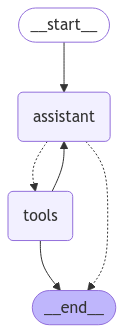

In [18]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(MessagesState)

def assistant(state: MessagesState):
  return {'messages': llm_with_tools.invoke(state['messages'])}


builder.add_node('assistant', assistant)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, 'assistant')
builder.add_conditional_edges('assistant',
                              # if latest message from assistant is a tool call -> tools condition routes to tools
                              # if latest message from assistant is not a tool call -> routes to END
                              tools_condition)

builder.add_edge('tools', "assistant")
builder.add_edge('tools', END)

graph = builder.compile()



from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [19]:
result = graph.invoke({'messages': ['Search how is the weather today in Karachi, Pakistan? Collect temperature, condition, humidity. If temperature greater than 30 then call it a hot day']})


In [20]:
from pprint import pprint

for m in result['messages']:
  m.pretty_print()

================================ Human Message =================================

Search how is the weather today in Karachi, Pakistan? Collect temperature, condition, humidity. If temperature greater than 30 then call it a hot day
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_g1z0)
 Call ID: call_g1z0
  Args:
    query: Karachi Pakistan weather today
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Karachi', 'region': 'Sindh', 'country': 'Pakistan', 'lat': 24.8667, 'lon': 67.05, 'tz_id': 'Asia/Karachi', 'localtime_epoch': 1737402830, 'localtime': '2025-01-21 00:53'}, 'current': {'last_updated_epoch': 1737402300, 'last_updated': '2025-01-21 00:45', 'temp_c': 16.1, 'temp_f': 61.0, 'is_day': 0, 'condition': {'text': 'Mist', 'icon': '//cdn.weatherapi.com/weather/64x64/n